# Part II - EDA of San Francisco Bay area bike sharing data
## by David Babalola

## Investigation Overview


> In this investigation, I wanted to look at the variables that affected the ride duration and distance. I focus on the following variables: member birth year, gender, user type, and bike share for all trip.


## Dataset Overview

> The dataset has records 183,412 rides and has 16 features. There are 7 columns that are floats, 2 of them are ints, while 7 are object (strings). The dataset has categorical variables such as member birth year, gender, user type, and bike share for all trip. Other variables include start/end longitude and latitude, start/end station name, bike id, etc.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
bikeData = pd.read_csv('201902-fordgobike-tripdata.csv')

### Data Cleaning

In [3]:
# 1. Drop rows with NaN
bikeData.dropna(inplace=True)

# 2. Convert columns to datetime
bikeData['start_time'] = bikeData['start_time'].astype('datetime64[ns]')
bikeData['end_time'] = bikeData['end_time'].astype('datetime64[ns]')
bikeData['member_birth_year'] = bikeData['member_birth_year'].astype('int')

# 3. Drop columns that are not needed
bikeData.drop(['start_station_id', 'end_station_id'], axis=1, inplace=True)

# 4. Convert categorical columns
nominal_var_dict = {'member_gender': ['Male', 'Female', 'Other'],
                    'user_type': ['Subscriber', 'Customer'],
                    'bike_share_for_all_trip': ['Yes', 'No']}

for var in nominal_var_dict:
    unordered_var = pd.api.types.CategoricalDtype(ordered = False, categories = nominal_var_dict[var])
    bikeData[var] = bikeData[var].astype(unordered_var)

### Feature Engineering (create ride distance column)

In [4]:
import math
def calculateHaversine(currentRow):
    """This function returns the haversine given the latitudes and longitudes for the start and end."""
    start_station_longitude = math.radians(currentRow['start_station_longitude'])
    end_station_longitude = math.radians(currentRow['end_station_longitude'])
    start_station_latitude = math.radians(currentRow['start_station_latitude'])
    end_station_latitude = math.radians(currentRow['end_station_latitude'])

    # Haversine formula
    diffOfLongitude = end_station_longitude - start_station_longitude
    diffOfLatitude = end_station_latitude - start_station_latitude

    a = math.sin(diffOfLatitude / 2)**2 + math.cos(start_station_latitude) * math.cos(end_station_latitude) * math.sin(diffOfLongitude / 2)**2
    c = 2 * math.asin(math.sqrt(a))

    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371

    # calculate the result
    return(c * r * 1000)

In [5]:
bikeData['ride_distance'] = bikeData.apply(lambda x: calculateHaversine(x), axis=1)

In [6]:
# Remove outliers
bikeDataFiltered = bikeData.query('duration_sec <= 3000')
#bikeDataFiltered = bikeData.query('ride_distance <= 7000')

In [7]:
# sample 1000 bike rides so that plots are clearer and they render faster
bike_rides_samp = bikeDataFiltered.sample(n=1000, replace = False)

## Distribution of Ride duration

> The durations of the rides in the dataset have a large range of values, from about 250 to over 20k plotted on a logarithmic scale, the distribution of ride duration takes on a unimodal shape. Most of the rides have a duration between 250 and 1000 seconds.

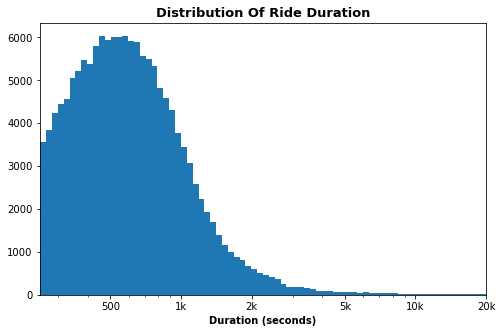

In [8]:
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(bikeData['duration_sec'].max())+log_binsize, log_binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikeData, x = 'duration_sec', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], 
           [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlim([250, 2e4])
plt.xlabel('Duration (seconds)', fontsize=10, weight='bold')
plt.title('Distribution of Ride duration'.title(), fontsize=13, weight='bold')
plt.show()

## Distribution of Ride Distance

> The distribution of the ride distance in the dataset is unimocal in nature. It also has a large range, with most values being betwween 250 and 5k metres.

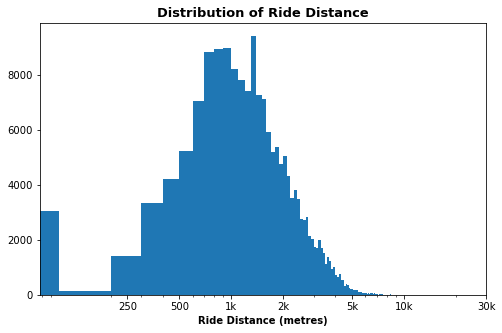

In [9]:
binsize = 100
bins = np.arange(0, bikeDataFiltered['ride_distance'].max()+binsize, binsize)

plt.figure(figsize=[8, 5])
plt.hist(data = bikeDataFiltered, x = 'ride_distance', bins=bins)
plt.xlabel('Ride Distance (metres)', fontsize=10, weight='bold')
plt.xscale('log')
plt.xticks([250, 500, 1e3, 2e3, 5e3, 1e4, 3e4], [250, 500, '1k', '2k', '5k', '10k', '30k'])
plt.title('Distribution of Ride Distance', fontsize=13, weight='bold')
plt.show()

## Ride Duration vs Member birth year
> The scatter plot shows that most of the rides were by members born between 1970 and 2000.


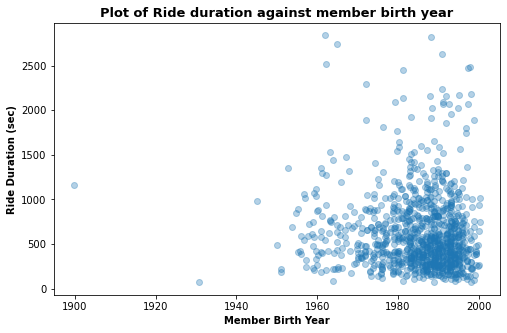

In [10]:
plt.figure(figsize=[8, 5])
sb.regplot(data = bike_rides_samp, x = 'member_birth_year', y = 'duration_sec', 
           truncate=False, x_jitter=0.3, scatter_kws={'alpha':1/3}, fit_reg=False);
plt.xlabel('Member Birth Year', fontsize=10, weight='bold')
plt.ylabel('Ride Duration (sec)', fontsize=10, weight='bold')
plt.title('Plot of Ride duration against member birth year', fontsize=13, weight='bold')
plt.show()

## Ride Duration and Distance vs user_type, gender, bike share for all trip
> The scatter plot shows the bivariate relationship between the variables we want to understand and some categorical variables.
From the visualization below, we observe that the distributions for both the ride_distance and duration_sec are quite similar across the categorical variables. We see that most Subscribers have a shorter ride distance and duration. We also see that males and females riders have similar distribution in terms of ride distance and duration. However, Other genders have a slightly higher average (median) ride duration and distance. Lastly, we see that regardless of whether the rider is enrolled in the bike share for all trip program or not, their distributions are similar; although those that are not enrolled in the program have a higher average (median) ride distance.


<Figure size 720x1080 with 0 Axes>

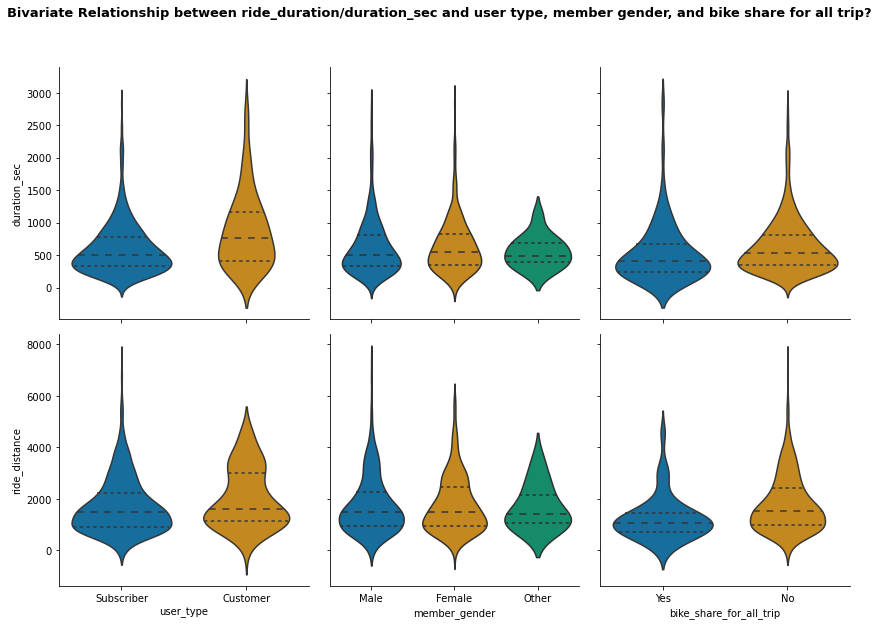

In [11]:
# plot matrix of duration_sec and ride_distance against categorical features.
categoric_vars = ['user_type', 'member_gender', 'bike_share_for_all_trip']
plt.figure(figsize = [10, 15]);
g = sb.PairGrid(data = bike_rides_samp, y_vars = ['duration_sec', 'ride_distance'], 
                x_vars = categoric_vars, height = 3, size = 4, palette='colorblind');
g.map(sb.violinplot, inner='quartiles');
g.fig.suptitle('Bivariate Relationship between ride_duration/duration_sec and user type, member gender, and bike share for all trip?', y=1.08, fontsize=13, weight='bold');
plt.show();

## Ride Duration and Distance vs birth year, user_type, and gender
> The charts below show multivariate relationships. It looks at the relationship between ride_distance/duration_sec and , birth year, user_type, and gender. We see that customers and people who identified with an _Other_ gender generally have an higher average ride duration and distance. We also see that some earlier years, particularly 1878 to 1948, have data for only Subscribers. For gender, many of those years only have data for a specific gender

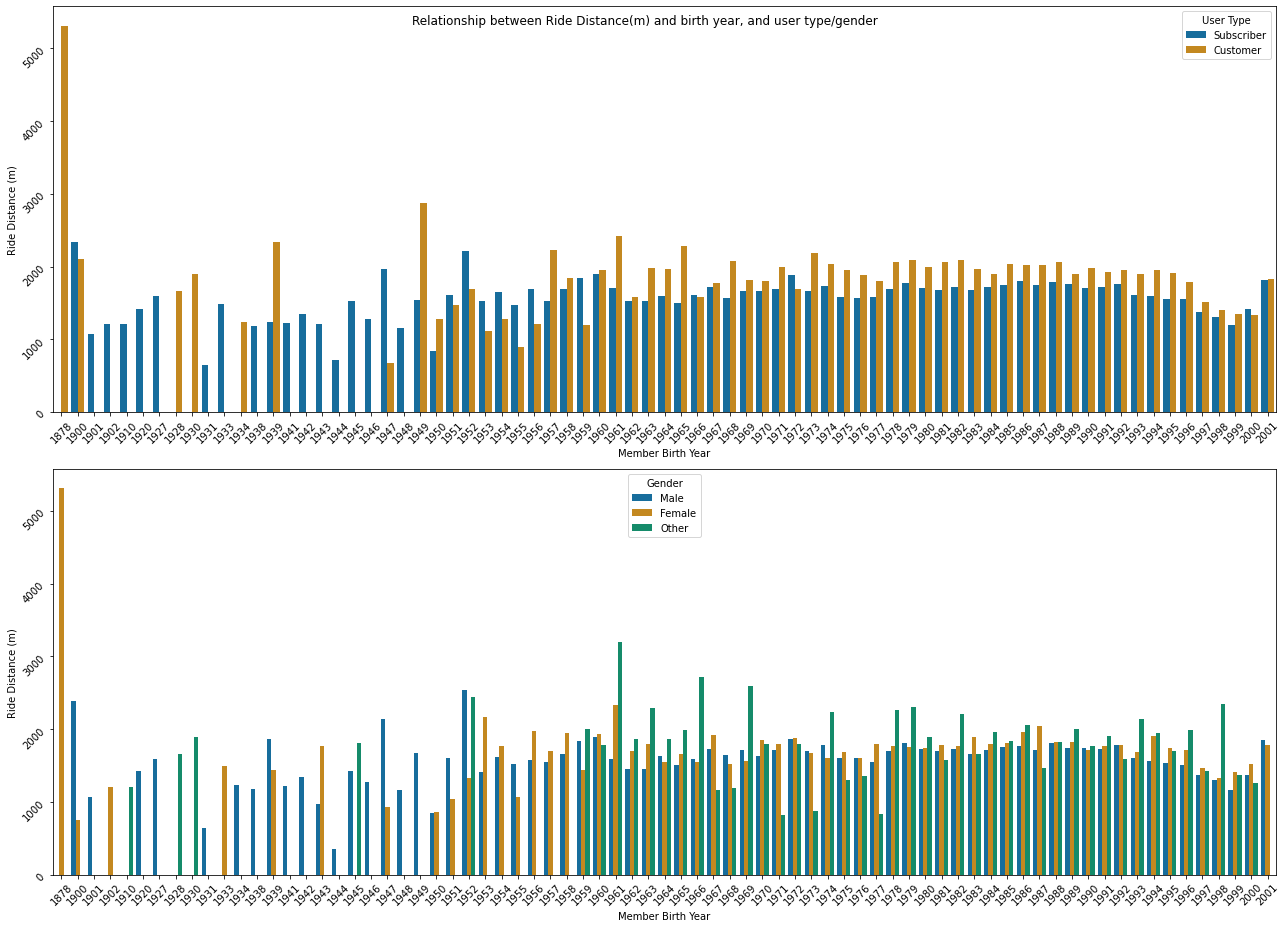

In [12]:
# plot matrix of duration_sec and ride_distance against categorical features.
fig, ax = plt.subplots(nrows = 2, figsize = [18,13])
sb.barplot(ax = ax[0], data = bikeDataFiltered, x = 'member_birth_year', y = 'ride_distance', hue = 'user_type',
           palette = 'colorblind', errwidth=0)
ax[0].set_xlabel("Member Birth Year")
ax[0].set_ylabel('Ride Distance (m)')
ax[0].legend(title='User Type')
ax[0].tick_params(labelrotation=45)
#plt.title('Relationship between ride distance, member birth year, and user type')

# Plot 2
sb.barplot(ax = ax[1], data = bikeDataFiltered, x = 'member_birth_year', y = 'ride_distance', hue = 'member_gender',
           palette = 'colorblind', errwidth=0)
ax[1].set_xlabel("Member Birth Year")
ax[1].set_ylabel("Ride Distance (m)")
ax[1].legend(title='Gender')
ax[1].tick_params(labelrotation=45)
#plt.title('Relationship between duration(sec), member birth year, and gender')

fig.tight_layout()
fig.suptitle('Relationship between Ride Distance(m) and birth year, and user type/gender')
plt.show()

## Ride Duration and Distance vs birth year, user_type, and gender

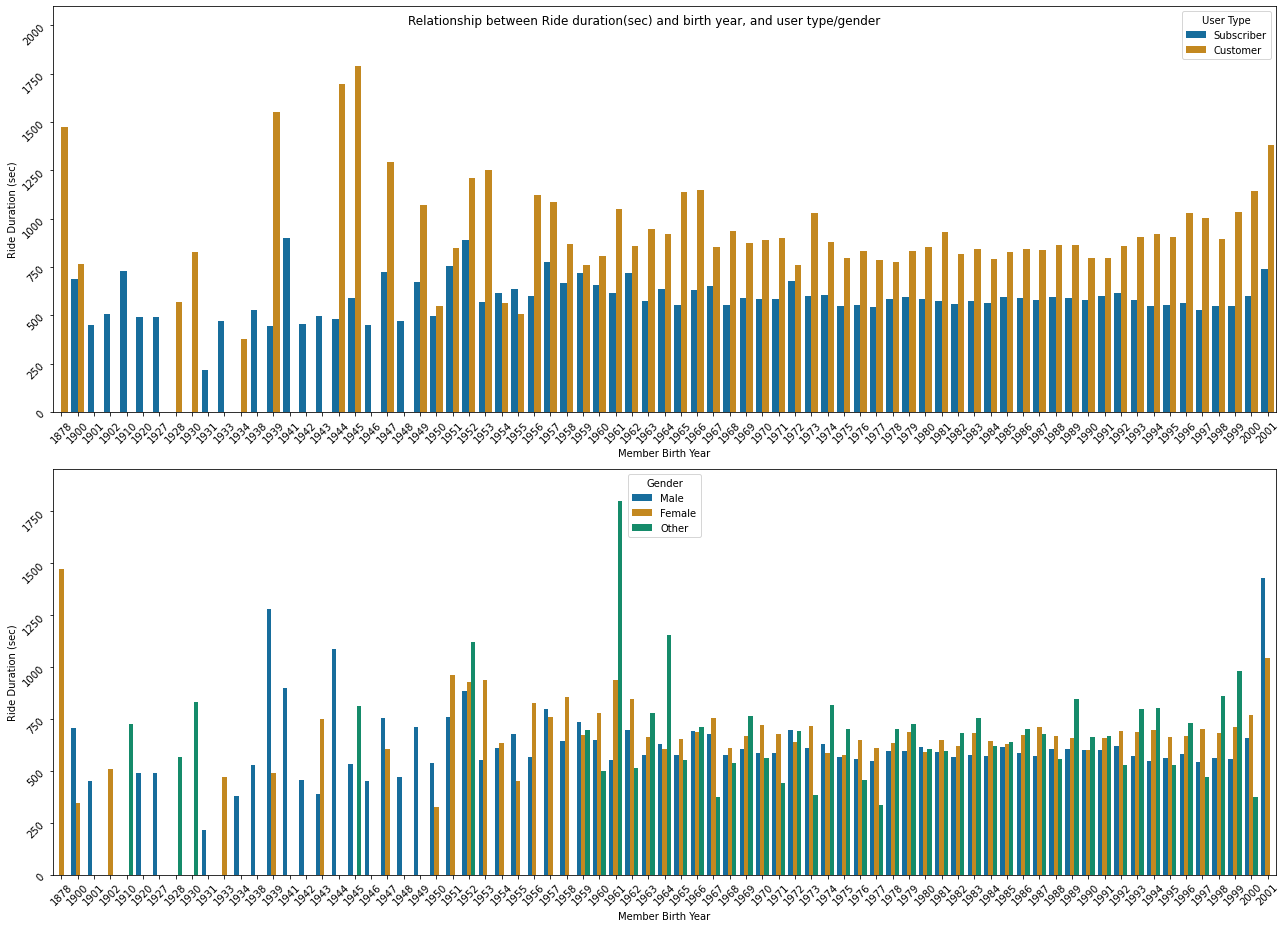

In [13]:
# plot matrix of duration_sec and ride_distance against categorical features.
fig, ax = plt.subplots(nrows = 2, figsize = [18,13])

# Plot 3
sb.barplot(ax = ax[0], data = bikeDataFiltered, x = 'member_birth_year', y = 'duration_sec', hue = 'user_type',
           palette = 'colorblind', errwidth=0)
ax[0].set_xlabel("Member Birth Year")
ax[0].set_ylabel("Ride Duration (sec)")
ax[0].legend(title='User Type')
ax[0].tick_params(labelrotation=45)
#plt.title('Relationship between duration(sec), member birth year, and gender')

# Plot 4
sb.barplot(ax = ax[1], data = bikeDataFiltered, x = 'member_birth_year', y = 'duration_sec', hue = 'member_gender',
           palette = 'colorblind', errwidth=0)
ax[1].set_xlabel("Member Birth Year")
ax[1].set_ylabel("Ride Duration (sec)")
ax[1].legend(title='Gender')
ax[1].tick_params(labelrotation=45)
#plt.title('Relationship between duration(sec), member birth year, and gender')

fig.tight_layout()
fig.suptitle('Relationship between Ride duration(sec) and birth year, and user type/gender')
plt.show()

In [14]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

^C
